# 14.5 2012联邦选举委员会数据库

美国联邦选举委员会发布了有关政治竞选赞助方面的数据。其中包括赞助者的姓名、职业、雇主、地址以及出资额等信息。我们对2012年美国总统大选的数据集比较感兴趣（http://www.fec.gov/disclosurep/PDownload.do）。我在2012年6月下载的数据集是一个150MB的CSV文件（P00000001-ALL.csv），我们先用pandas.read_csv将其加载进来：

In [1]:
import pandas as pd
import numpy as np

In [2]:
fec = pd.read_csv('../../datasets/fec/P00000001-ALL.csv')
fec.info()

/tmp/ipykernel_144620/2747453926.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  fec = pd.read_csv('../../datasets/fec/P00000001-ALL.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

该DataFrame中的记录如下所示：

In [3]:
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                        50.0
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

你可能已经想出了许多办法从这些竞选赞助数据中抽取有关赞助人和赞助模式的统计信息。我将在接下来的内容中介绍几种不同的分析工作（运用到目前为止已经学到的方法）。

不难看出，该数据中没有党派信息，因此最好把它加进去。通过unique，你可以获取全部的候选人名单：

In [5]:
unique_cands = fec.cand_nm.unique()

unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [6]:
unique_cands[2]

'Obama, Barack'

指明党派信息的方法之一是使用字典：

In [7]:
parties = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

现在，通过这个映射以及Series对象的map方法，你可以根据候选人姓名得到一组党派信息：

In [8]:
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [9]:
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [11]:
# Add it as a column
fec['party'] = fec.cand_nm.map(parties)

fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

这里有两个需要注意的地方。第一，该数据既包括赞助也包括退款（负的出资额）：

In [12]:
(fec.contb_receipt_amt > 0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

为了简化分析过程，我限定该数据集只能有正的出资额：

In [13]:
fec = fec[fec.contb_receipt_amt > 0]

由于Barack Obama和Mitt Romney是最主要的两名候选人，所以我还专门准备了一个子集，只包含针对他们两人的竞选活动的赞助信息：

In [14]:
fec_mrbo = fec[fec.cand_nm.isin(['Obama, Barack','Romney, Mitt'])]

## 根据职业和雇主统计赞助信息

基于职业的赞助信息统计是另一种经常被研究的统计任务。例如，律师们更倾向于资助民主党，而企业主则更倾向于资助共和党。你可以不相信我，自己看那些数据就知道了。首先，根据职业计算出资总额，这很简单：

In [15]:
fec.contbr_occupation.value_counts()[:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

不难看出，许多职业都涉及相同的基本工作类型，或者同一样东西有多种变体。下面的代码片段可以清理一些这样的数据（将一个职业信息映射到另一个）。注意，这里巧妙地利用了dict.get，它允许没有映射关系的职业也能“通过”：

In [16]:
occ_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
   'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x, x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

我对雇主信息也进行了同样的处理：

In [17]:
emp_mapping = {
   'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
   'INFORMATION REQUESTED' : 'NOT PROVIDED',
   'SELF' : 'SELF-EMPLOYED',
   'SELF EMPLOYED' : 'SELF-EMPLOYED',
}


# If no mapping provided, return x
f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

现在，你可以通过pivot_table根据党派和职业对数据进行聚合，然后过滤掉总出资额不足200万美元的数据：

In [18]:
by_occupation = fec.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='party', 
                                aggfunc='sum'
                               )

over_2mm = by_occupation[by_occupation.sum(1) > 2000000]

over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
CEO,2074974.79,4211040.52
CONSULTANT,2459912.71,2544725.45
ENGINEER,951525.55,1818373.70
EXECUTIVE,1355161.05,4138850.09
HOMEMAKER,4248875.80,13634275.78
INVESTOR,884133.00,2431768.92
LAWYER,3160478.87,391224.32
MANAGER,762883.22,1444532.37


把这些数据做成柱状图看起来会更加清楚（'barh'表示水平柱状图，如图14-12所示）：

<Axes: ylabel='contbr_occupation'>

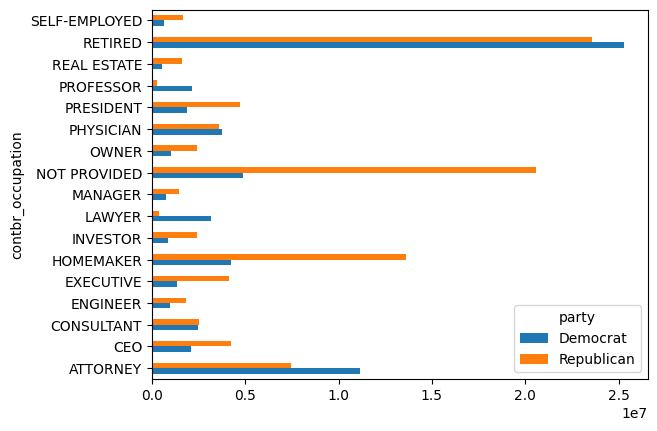

In [19]:
over_2mm.plot(kind='barh')

你可能还想了解一下对Obama和Romney总出资额最高的职业和企业。为此，我们先对候选人进行分组，然后使用本章前面介绍的类似top的方法：

In [20]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)

然后根据职业和雇主进行聚合：

In [21]:
grouped = fec_mrbo.groupby('cand_nm')


grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [22]:
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

## 对出资额分组

还可以对该数据做另一种非常实用的分析：利用cut函数根据出资额的大小将数据离散化到多个面元中：

In [23]:
bins = np.array([0, 1, 10, 100, 1000, 10000,100000, 1000000, 10000000])


labels = pd.cut(fec_mrbo.contb_receipt_amt, bins)


labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

现在可以根据候选人姓名以及面元标签对奥巴马和罗姆尼数据进行分组，以得到一个柱状图：

In [24]:
grouped = fec_mrbo.groupby(['cand_nm', labels])


grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


从这个数据中可以看出，在小额赞助方面，Obama获得的数量比Romney多得多。你还可以对出资额求和并在面元内规格化，以便图形化显示两位候选人各种赞助额度的比例（见图14-13）：

In [25]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)


normed_sums = bucket_sums.div(bucket_sums.sum(axis=1), axis=0)


normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,0.000000
"(1000000, 10000000]",1.000000,0.000000


<Axes: ylabel='contb_receipt_amt'>

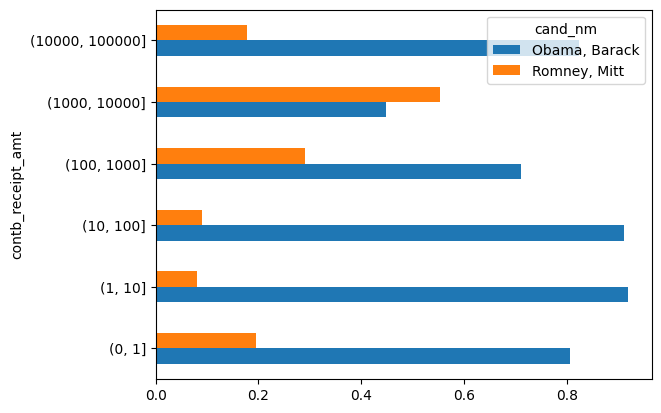

In [26]:
normed_sums[:-2].plot(kind='barh')

我排除了两个最大的面元，因为这些不是由个人捐赠的。

还可以对该分析过程做许多的提炼和改进。比如说，可以根据赞助人的姓名和邮编对数据进行聚合，以便找出哪些人进行了多次小额捐款，哪些人又进行了一次或多次大额捐款。我强烈建议你下载这些数据并自己摸索一下。

## 根据州统计赞助信息

根据候选人和州对数据进行聚合是常规操作：

In [27]:
grouped = fec_mrbo.groupby(['cand_nm', 'contbr_st'])


totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)


totals = totals[totals.sum(1) > 100000]


totals[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


如果对各行除以总赞助额，就会得到各候选人在各州的总赞助额比例：

In [28]:
percent = totals.div(totals.sum(1), axis=0)


percent[:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224


# 14.6 总结

我们已经完成了正文的最后一章。附录中有一些额外的内容，可能对你有用。

本书第一版出版已经有5年了，Python已经成为了一个流行的、广泛使用的数据分析语言。你从本书中学到的方法，在相当长的一段时间都是可用的。我希望本书介绍的工具和库对你的工作有用。